In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
from matplotlib import pyplot as plt
import matplotlib as mpl
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


# Applications

In this chapter, we have covered some of the basics of text problems and language processing, we also covered how to build text classifier by different approaches such as n-gram based vextorizer, and text embedding. 
In this last section of the chapter, we will first shown an example of using the text classifier to classify newly accquired text content. We will then show a use of the text features for the problem of text data retrival.

```{index} web scraping
```

```{index} Beautifulsoup
```

## Classifying a given text


One common method for acquiring new text data to feed into a text classifier is called web scraping. We will use a convenient tool called `BeautifulSoup` to scrape the content of a web page, then run the scraped text content through the UNSDG classifier that we have built over the previous sections. `BeautifulSoup` provides a functionality to parse a web request response into HTML elements with their tags (i.e., it breaks down any web page into its smaller sections, like the paragraphs, images, etc). Searching through the paragraph tags will grab the majority of the content of a web page. 

To get started, we first import the `requests` library and `BeautifulSoup` itself. We will then go to the official UN website and read in one of their news stories.

In [3]:
import requests
from bs4 import BeautifulSoup
url = "https://news.un.org/en/story/2023/07/1138767"
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")

We then use the NLTK sentence tokenizer to break the web page content into sentences.

In [4]:
from nltk import sent_tokenize
page_sentences = []
for tag in soup.find_all('p'):
        if (len(tag.text)>=30):
            sentences = sent_tokenize(tag.text)
            page_sentences = page_sentences + sentences
page_sentence_df = pd.DataFrame({"text": page_sentences})
page_sentence_df.text

0     New data from the World Health Organization (W...
1     Global immunisation services reached four mill...
2     Data published by the UN agencies on Monday re...
3     DTP vaccinations are commonly used as the glob...
4     Despite the improvement, this figure is still ...
5     “These data are encouraging, and a tribute to ...
6     “But global and regional averages don’t tell t...
7     When countries and regions lag, children pay t...
8     The early stages of recovery in immunisation r...
9     Progress in well-resourced countries with larg...
10    Of the 73 countries that recorded substantial ...
11    Vaccination against measles, one of the most i...
12    Last year, 21.9 million children – 2.7 million...
13    This has placed children in under-vaccinated c...
14    Data indicates countries with sustained immuni...
15    South Asia, which reported gradual increases i...
16    The African region, which is lagging behind in...
17    As population size increases, countries mu

Using these sentences, we could train a classification model like we did in Section 4, but we could also increase the training portion of labeled data, say 90% of the labeled data for training and only 10% just to get a confirmative check on the model. 

:::{admonition} Exercise 6.1
Why is it the case that we can use more data for training in this case?
:::

First we read in the training data. Notice that we put the scripts used in previous sections into a function. As with previous sections, make sure to adjust the loading of data to fit your directories.

```python
file_name = "[your-directory]/osdg-community-data-v2023-01-01.csv"
text_df = get_text_df(file_name)
```

In [5]:
def get_text_df(file_name):
    text_df = pd.read_csv(file_name, sep = "\t", quotechar='"')
    col_names = text_df.columns.values[0].split('\t')
    text_df[col_names] = text_df[text_df.columns.values[0]].apply(lambda x: pd.Series(str(x).split("\t")))
    text_df.drop(text_df.columns.values[0],axis = 1, inplace=True)
    text_df = text_df.astype({'sdg':int, 'labels_negative': int, 'labels_positive':int, 'agreement': float}, copy=True)
    text_df = text_df.query("agreement > 0.5 and (labels_positive - labels_negative) > 2")
    text_df.reset_index(drop=True, inplace=True)
    return text_df

In [ ]:
file_name = "/Users/jonathanzhu/Documents/data/osdg-community-data-v2023-01-01.csv"
text_df = get_text_df(file_name)

We then train a classifier using `CountVectorizer` to generate the features vector and train a multinomial Naive Bayes classifer.

              precision    recall  f1-score   support

           1     0.7223    0.8274    0.7713       481
           2     0.8475    0.7563    0.7993       316
           3     0.8926    0.9243    0.9082       674
           4     0.8338    0.9479    0.8872       863
           5     0.7570    0.9380    0.8379       920
           6     0.8653    0.8839    0.8745       465
           7     0.7469    0.9096    0.8203       730
           8     0.8125    0.3314    0.4708       353
           9     0.8497    0.5000    0.6296       328
          10     0.7970    0.4141    0.5450       256
          11     0.8383    0.7294    0.7801       462
          12     0.9098    0.5115    0.6549       217
          13     0.7243    0.8600    0.7864       443
          14     0.9171    0.6730    0.7763       263
          15     0.8987    0.6805    0.7745       313
          16     0.8860    0.9849    0.9328      1057

    accuracy                         0.8184      8141
   macro avg     0.8312   

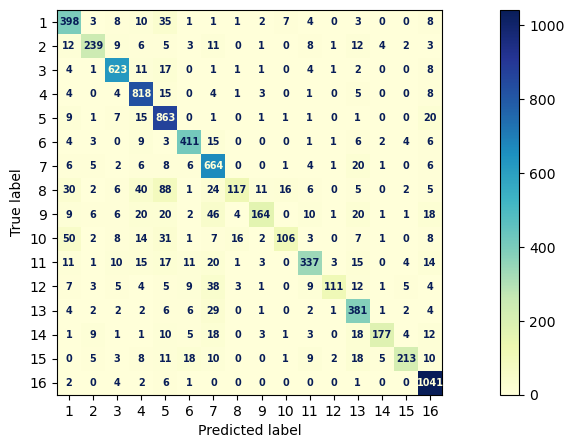

In [6]:
docs = text_df.text
categories = text_df.sdg
X_train, X_test, y_train, y_test = \
    train_test_split(docs, categories, test_size=0.33, random_state=7)

X_train_count_vectorizer = CountVectorizer(ngram_range=(2,2), stop_words = "english" )
X_train_count_vectorizer.fit(X_train)  
X_train_count_vector = X_train_count_vectorizer.transform(X_train) 
X_test_count_vector = X_train_count_vectorizer.transform(X_test) 

count_multinomialNB_clf = MultinomialNB().fit(X_train_count_vector, y_train)
y_pred = count_multinomialNB_clf.predict(X_test_count_vector)

fig, ax = plt.subplots(figsize=(15, 5))
font = {'family': 'sans-serif', 'weight': 'heavy','size': 7,} # set font for displaying confusion matrix
cm = mpl.colormaps["YlGnBu"] # set the color map for displaying confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, text_kw=font, ax=ax, cmap=cm)
print(metrics.classification_report(y_test,y_pred, digits = 4))


First, we run the classifier as if each sentence is a document and will be classified into its respective UNSDG. We can see the results indicate that more sentences are about SDG 3, which is "Good Health and Well Being", SDG 1 "No Poverty", and SDG 5 "Gender Equality".

In [7]:
page_count_vector = X_train_count_vectorizer.transform(page_sentence_df.text) 
page_pred = count_multinomialNB_clf.predict(page_count_vector)
pd.DataFrame(page_pred).value_counts()

3     10
1      8
5      7
16     5
4      2
11     1
dtype: int64

:::{admonition} Exericse 6.2
Repeat the above classification of the new data with Ridge and Mulitlayer Perceptron classifications. What differences exist?
:::

We can put all sentences of the web page content into one text documeent and classify the entire page content into SDG. We can see the result shows the web page is about SDG 3, "Good Health and Well Being".


In [8]:
page_count_vector = X_train_count_vectorizer.transform(pd.Series(page_sentence_df.text.str.cat()))
page_pred = count_multinomialNB_clf.predict(page_count_vector)
page_pred

array([3])

:::{admonition} Exercise 6.3
Read the news article at https://www.rockefellerfoundation.org/commitment/economic-equity/. What goal would you classify it as? What goal does the Naive Bayes model classify the document and each sentence as?
:::

```{index} similarity retrieval
```

## Similarity Retrieval

In essence, similarity retrieval is the process of item retrieval based on similarity. It is most common and familiar in the context of product recommendation for online shopping, but it can be used for documents as well where each document is simply treated as an item.

The problem itself can be boiled down to **estimating a utility function that predicts how much a user will "like" an item**; this terminology derives from online retail recommendations, but a very similar process exists for document similarity. In the context of documents, this utility would most likely be measured in terms of engagement with the document (for example, how long the user spent reading it, or if they read it at all), and we would most likely build recommendations purely based off of content similarity.

The most common way to perform this task is to start by making a **document-token interaction matrix**. In these matrices, each document in our dataset corresponds to one row, and each token corresponds to a column. Each entry $(x_i, y_j)$ of the matrix then corresponds to the number of instances of token $j$ in document $i$. 

To define similarity, then, we can treat each row or column as a vector and look at how similar any two vectors are. Note that we would use row vectors to determine similarity between documents and column vectors to determine similarity between token occurrences. Similarity is then mathematically computed as **cosine similarity**, where for any two vectors $\overrightarrow{A}$ and $\overrightarrow{B}$, the similarity is the cosine of the angle between them, or 

$$
\cos(\theta) = \frac{\overrightarrow{A} \cdot \overrightarrow{B}}{\|\overrightarrow{A}\| \times \|\overrightarrow{B}\|} = \frac{\sum_{i = 1}^{n} A_i B_i}{\sqrt{\sum_{i = 1}^{n} A_i^2}\sqrt{\sum_{i = 1}^{n} B_i^2}}
$$

:::{admonition} Exericse 6.3
Would high similarity indicate a lower or higher cosine similarity score? Why?
:::

To implement this in our code, we first return to the `tensorflow` package.

```python
import tensorflow as tf
import tensorflow_hub as hub

file_name = "[your-directory]/osdg-community-data-v2023-01-01.csv"
text_df = get_text_df(file_name)

embed = hub.load("[your-directory]/universal-sentence-encoder_4")

text_df["embedding"] = list(embed(text_df.text))
```

In [9]:
import tensorflow as tf
import tensorflow_hub as hub

file_name = "/Users/jonathanzhu/Documents/data/osdg-community-data-v2023-01-01.csv"
text_df = get_text_df(file_name)

embed = hub.load("/Users/jonathanzhu/Documents/bookchapter/source/universal-sentence-encoder_4")

text_df["embedding"] = list(embed(text_df.text))

2023-07-19 21:51:58.929465: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


We will also make a dataframe with all of the sentences:

In [ ]:
def get_sentence_df(text_df):
    text_df_sentence = []
    text_df_sdg = []
    text_df_text_id = []
    embedding = []
    for (text, sdg, text_id) in iter(zip(text_df.text, text_df.sdg, text_df.text_id)):
        temp_sentence = sent_tokenize(text)
        text_df_sentence = text_df_sentence + temp_sentence
        text_df_sdg = text_df_sdg + [sdg]*len(temp_sentence)
        text_df_text_id = text_df_text_id + [text_id]*len(temp_sentence)
        embedding = embedding + list(embed(temp_sentence))
    sentence_df = pd.DataFrame({"text": text_df_sentence, 
                                "sdg": text_df_sdg, 
                                "text_id": text_df_text_id,
                                "embedding": embedding})
    return sentence_df

sentence_df = get_sentence_df(text_df)

The process of generating similarity will result in a similarity heatmap as shown below. This heatmap can be thought of as a square matrix where each row and column represents a document, and the color of each entry represents the similarity between the documents.

<Axes: >

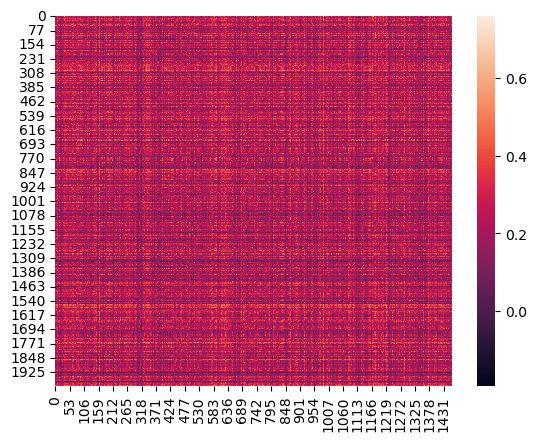

In [ ]:
sns.heatmap(np.array(np.inner(text_df.query("sdg == 3").embedding.tolist(), \
                              text_df.query("sdg == 1").embedding.tolist())))

Since we have a lot of documents, it might not make much sense to make a huge heatmap as it is not entirely visible.

:::{admonition} Exercise 6.5
Modify the code to generate a heatmap of only 40 documents.
:::

<Axes: >

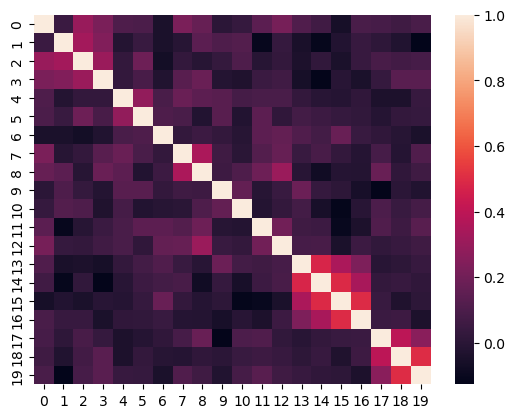

In [ ]:
sns.heatmap(np.array(np.inner(sentence_df.embedding[:20].tolist(), \
                              sentence_df.embedding[:20].tolist())))

:::{admonition} Exercise 6.6
Generate the heatmap for all the sentences.
:::

If we want to actually return the documents that are most similar to one that we choose (or any sentence of our choosing), we write a function that returns the $n$ most similar documents or sentences:

In [ ]:
def get_most_similar(text_df, sentence, n = 5):
    sentence_sim = np.inner(list(text_df.embedding), embed([sentence]))
    val = sorted(sentence_sim, reverse=True)[n]
    return text_df[sentence_sim > val].text

We can then test our function by running it on an example sentence, starting by looking at the most similar sentences from our dataset:

In [ ]:
s = "countries are working hard to save the ocean aminals."
get_most_similar(sentence_df, sentence = s, n=5)

1566      For indeed, there is no agency for ocean issues.
16750    As an island nation surrounded by the sea, we ...
78771    I think no country in the world can protect th...
86262    The rich countries also have a responsibility ...
87077    Governments investing in marine biotechnology ...
Name: text, dtype: object

:::{admonition} Exercise 6.7
What <i>documents</i> are the most similar to our example sentence?
:::

:::{admonition} Exercise 6.8
Generate a similarity heatmap for the documents classified as SDG 1 and SDG 3.
:::

## More Exercises

:::{admonition} Exercise 6.9
Write a function that takes a URL website as a string and returns the most similar documents in our dataset.
:::

:::{admonition} Exercise 6.10
Run the function from Exercise 6.9 on the following websites:

 - http://gianttortoise.org/en/beyond-tracking
 - https://www.dhs.gov/blue-campaign/what-human-trafficking
 - https://www.dol.gov/agencies/odep/program-areas/individuals/older-workers
 - https://michigantoday.umich.edu/2022/08/26/positively-breaking-the-age-code/

Do the most similar documents seem reasonable?
:::